In [8]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler

# fetch dataset 
iris = fetch_ucirepo(id=53) 

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
X = iris.data.features 
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = iris.data.targets

# load the dataloader
from torch.utils.data import DataLoader

In [9]:
y = y.copy()
y["class"] = y["class"].replace({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})

In [10]:
# convert to a pytorch tensor
data = torch.tensor(X.values).float()
labels = torch.tensor(y.values).float()
labels = labels.view(-1, 1)
labels=labels.squeeze().long()

# Break the data into batches

In [11]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# the model

In [12]:
# a function that creates the ANN model

def model(L2lambda):

    # model architecture
    ANN = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optim
    optim = torch.optim.SGD(ANN.parameters(),lr=.005,weight_decay=L2lambda)

    return ANN,lossfunc,optim

In [13]:
# train the model

# global parameter
epochs = 1000

def train():

    # initialize accuracies as empties
    train_accuracy = []
    test_accuracy  = []
    losses   = []

    # loop over epochs
    for i in range(epochs):

        # loop over training data batches
        batch_accuracy  = []
        batch_loss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = ANN(X)
            loss = lossfunc(yHat,y)

            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()

            # compute training accuracy just for this batch
            batch_accuracy.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
            batch_loss.append( loss.item() )
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        train_accuracy.append( np.mean(batch_accuracy) )
        losses.append( np.mean(batch_loss) )

        # test accuracy
        ANN.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax( ANN(X),axis=1 )
        test_accuracy.append( 100*torch.mean((predlabels == y).float()).item() )

        # no worries, reset here ;)
        ANN.train()

    # function output
    return train_accuracy,test_accuracy,losses


In [14]:
# create a model
L2lambda = .01
ANN,lossfunc,optim = model(L2lambda)

# train the model
train_accuracy,test_accuracy,losses = train()


In [15]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))

ax[1].plot(train_accuracy,'ro-')
ax[1].plot(test_accuracy,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [16]:
# create a 1D smoothing filter
def smooth(x,k):
    return np.convolve(x,np.ones(k)/k,mode='same')

# The experiment

In [17]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(l2lambdas)))
accuracyResultsTest  = np.zeros((numepochs,len(l2lambdas)))


# loop over batch sizes
for li in range(len(l2lambdas)):

    # create and train a model
    ANN,lossfunc,optim = model(l2lambdas[li])
    train_accuracy,test_accuracy,losses = train()

    # store data
    accuracyResultsTrain[:,li] = smooth(train_accuracy,10)
    accuracyResultsTest[:,li]  = smooth(test_accuracy,10)

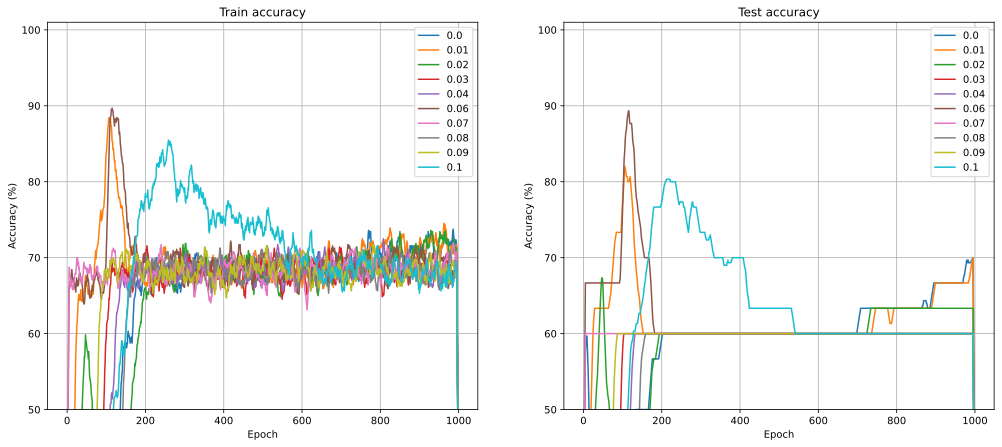

In [18]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

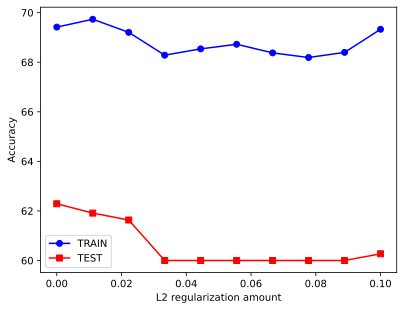

In [19]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Experiments

1) In this experiment, we have shown that L2 regularization has a negative impact on small, or simple, architectures. Based on our previous discussion (see ppt) L2 regularization only benefits large and complex models. For this experiment, modify the model architecture to have more than two hidden layers and increase the number of epochs. Note: Set seed your experiment.

2) Experiment with combining L2 regularization and dropout.